In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from pathlib import Path
from typing import Tuple

import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
%pylab inline
import matplotlib.pyplot as plt
from matplotlib import patches
rcParams['figure.figsize'] = 10, 10

Populating the interactive namespace from numpy and matplotlib


In [3]:
input_path = Path('/media/klaus/Ondrag/dev/datasets/300VW_Dataset_2015_12_14')
temp_path = Path('/media/klaus/Ondrag/dev/datasets/300VW_Dataset_2015_12_14_temp')
output_path = Path('/media/klaus/Ondrag/dev/datasets/300VW_Dataset_2015_12_14_processed')
n_videos = 114
n_points = 68
padding = 0
expand_ratio = 0.5
image_quality = 100
output_height, output_width = 128, 128

In [4]:
all_videos = sorted([p for p in input_path.iterdir() if p.is_dir()])
assert len(all_videos) == n_videos
n_images_per_video = [
    len(list((video_path / 'annot').glob('*.pts')))
    for video_path in tqdm(all_videos, desc='video')
]
n_images = sum(n_images_per_video)

print(f'n images: {n_images}')


n images: 218597


In [5]:
for video_input_path, n_images_in_video in tqdm(list(zip(all_videos, n_images_per_video)), 
                                                desc='video'):
    frames_output_dir = temp_path / video_input_path.stem / 'images'
    if frames_output_dir.exists() and len(list(frames_output_dir.iterdir())) == n_images_in_video:
        continue
    
    frames_output_dir.mkdir(exist_ok=True, parents=True)
    avi_path = video_input_path / 'vid.avi'
    video = cv2.VideoCapture(str(avi_path))
    
    counter = 1
    success, image = video.read()
    while success == 1:
        frame_output_path = frames_output_dir / f'{counter:06d}.jpg'
        cv2.imwrite(str(frame_output_path), image, [int(cv2.IMWRITE_JPEG_QUALITY), image_quality])
        counter += 1
        success, image = video.read()

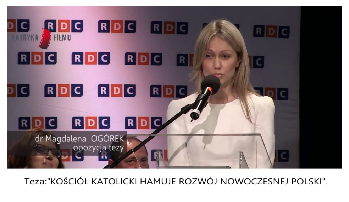

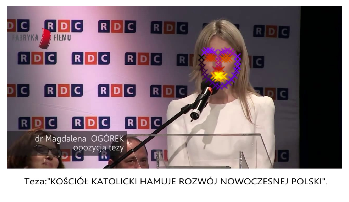

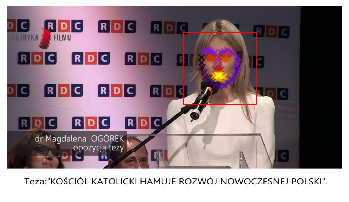

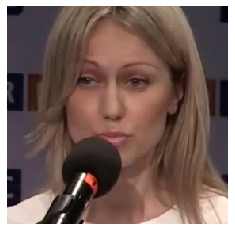

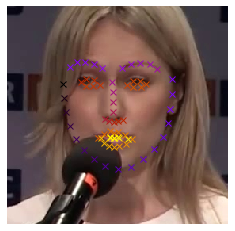

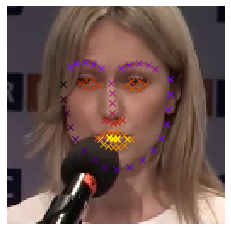

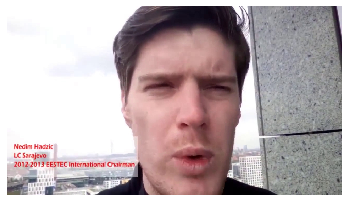

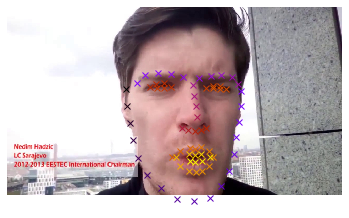

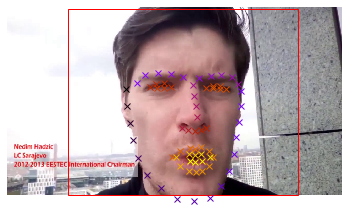

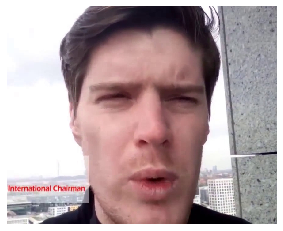

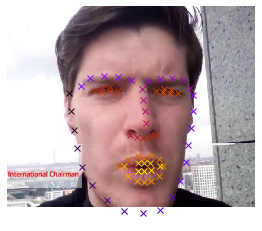

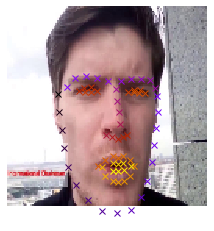

In [9]:
def load_pts_file(file_path: Path) -> np.ndarray:
    with open(str(file_path), 'r') as file:
        lines = file.readlines()
        
    assert lines[0].strip().startswith('version: 1'), str(file_path)
    assert lines[1] == f'n_points: {n_points}\n', str(file_path)
    
    lines = [l.strip() for l in lines]
    # remove
    # version: 1
    # n_points: 68
    # {
    lines = lines[3:]
    # remove
    # }
    lines = lines[:-1]
    points = [[float(x) for x in p.split()]
              for p in lines]
    points = np.asarray(points)
    assert points.shape == (n_points, 2)
    return points


def points_to_box(points: np.ndarray, image_size: Tuple[int, int]) -> Tuple[float, float, float, float]:
    x1, y1, x2, y2 = [points[:, 0].min(), points[:, 1].min(), points[:, 0].max(), points[:, 1].max()]
    x1, y1 = [t - padding for t in (x1, y1)]
    x2, y2 = [t + padding for t in (x2, y2)]
    box_height, box_width = y2 - y1 + 1, x2 - x1 + 1
    assert box_height > 1 and box_width > 1
    
    if expand_ratio is not None:
        box_height *= expand_ratio
        box_width *= expand_ratio
        x1, y1 = [math.floor(t - s) for t, s in zip((x1, y1), (box_width, box_height))]
        x2, y2 = [math.ceil(t + s) for t, s in zip((x2, y2), (box_width, box_height))]
    
    image_height, image_width, _ = image_size
    # landmarks can be out of image, but that's okay, we'll still export them.
    x1, y1 = [t if t >= 0 else 0 for t in (x1, y1)]
    x2, y2 = [t if t < m else m for t, m in zip((x2, y2), (image_width, image_height))]
    assert x1 <= x2 and y1 <= y2
    
    return x1, y1, x2, y2


def extract(image: np.ndarray, box: Tuple[float, float, float, float]) -> np.ndarray:
    x1, y1, x2, y2 = box
    extraction = image[y1:y2+1, x1:x2+1, ...]
    return extraction


def offset_points(points: np.ndarray, box: Tuple[float, float, float, float]) -> np.ndarray:
    x1, y1, x2, y2 = box
    points = copy(points)
    points[:, 0] -= x1
    points[:, 1] -= y1
    return points


def rescale_image(image: np.ndarray) -> np.ndarray:
    _, _, n_channels = image.shape
    image = cv2.resize(image, dsize=(output_width, output_height), interpolation=cv2.INTER_CUBIC)
    assert image.shape == (output_height, output_width, n_channels)    
    return image


def rescale_points(points: np.ndarray, image_shape: Tuple[int, int, int]) -> np.ndarray:
    height, width, n_channels = image_shape    
    points = copy(points)
    height_factor = 1 / height * output_height
    width_factor = 1 / width * output_width
    points[:, 0] *= width_factor
    points[:, 1] *= height_factor    
    return points


def plot(image, points: np.ndarray = None, box: Tuple[int, int, int, int] = None) -> None:
    plt.figure()
    plt.imshow(image)
    plt.axis('off')

    if points is not None:
        cmap = plt.get_cmap('gnuplot')
        colors = [cmap(i) for i in np.linspace(0, 1, len(points))]
        for index, c in zip(range(len(points)), colors):
            plt.plot([points[index, 0]], [points[index, 1]], 'x', color=c)
    
    if box is not None:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax = plt.gca()
        ax.add_patch(rect)
    
    plt.show()


def visualize(video_id: str, frame_id: str) -> None:
    annotation_input_path = input_path / video_id / 'annot' / f'{frame_id}.pts'
    frame_input_path = temp_path / video_id / 'images' / f'{frame_id}.jpg'
    image = cv2.imread(str(frame_input_path))
    image_points = load_pts_file(str(annotation_input_path))
    image_box = points_to_box(image_points, image.shape)
    
    extraction = extract(image, image_box)
    extraction_points = offset_points(image_points, image_box)
    
    output = rescale_image(extraction)
    output_points = rescale_points(extraction_points, extraction.shape)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plot(image)
    plot(image, image_points)
    plot(image, image_points, image_box)
    extraction = cv2.cvtColor(extraction, cv2.COLOR_BGR2RGB)
    plot(extraction)
    plot(extraction, extraction_points)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plot(output, output_points)
    

visualize('001', '000001')
visualize('007', '000020')
# visualize('010', '000001')

In [ ]:
return None
for video_input_path in tqdm(all_videos, desc='video'):
    video_output_path = output_path / video_input_path.stem
    annotations_output_dir = video_output_path / 'annotations'
    annotations_output_dir.mkdir(exist_ok=True, parents=True)
    frames_output_dir = video_output_path / 'images'
    frames_output_dir.mkdir(exist_ok=True, parents=True)
    
    for annotation_input_path in tqdm(sorted(list((video_input_path / 'annot').glob('*.pts'))),
                                      desc='frame', leave=False):
        frame_output_path = frames_output_dir / f'{annotation_input_path.stem}.jpg'
        annotation_output_path = annotations_output_dir / f'{annotation_input_path.stem}.txt'
        if frame_output_path.exists() and annotation_output_path.exists():
            continue
        
        frame_input_path = temp_path / video_input_path.stem / 'images' / f'{annotation_input_path.stem}.jpg'
        image = cv2.imread(str(frame_input_path))
        image_points = load_pts_file(str(annotation_input_path))
        image_box = points_to_box(image_points, image.shape)
        
        extraction = extract(image, image_box)
        extraction_points = offset_points(image_points, image_box)
        
        if not frame_output_path.exists():
            output = rescale_image(extraction)
            cv2.imwrite(str(frame_output_path), output, [int(cv2.IMWRITE_JPEG_QUALITY), image_quality])
        
        if not annotation_output_path.exists():
            output_points = rescale_points(extraction_points, extraction.shape)
            np.savetxt(str(annotation_output_path), output_points)